# Exercise 4 Camera calibration 

In this exercise we will look at:
- Direct linear transform (DLT), linear algorithm for camera calibration and
- Checkerboard calibration, and bundle adjustment from Zhang (2000).

You should be able to perform camera calibration using both methods.

In [1]:
from ex1 import box3d, projectpoints
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2
from scipy.spatial.transform import Rotation

#### 4.1 DLT Direct linear transformation

In [2]:
# Pose matrices:
R = np.array([[np.sqrt(0.5), -np.sqrt(0.5), 0], [np.sqrt(0.5), np.sqrt(0.5), 0], [0, 0, 1]])
t = np.array([[0, 0, 10]]).T

f = 1000
dx = 1920//2
dy = 1080//2
K = np.array([[f, 0, dx], [0, f, dy], [0, 0, 1]])
K

array([[1000,    0,  960],
       [   0, 1000,  540],
       [   0,    0,    1]])

In [3]:
# Exact 3D points
Q = np.array([[0, 1, 0, 1, 0, 1, 0, 1], [0, 0, 1, 1, 0, 0, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1]])
Q

array([[0, 1, 0, 1, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1]])

In [4]:
P_exact = K@np.hstack((R, t))
np.int32(P_exact)

array([[ 707, -707,  960, 9600],
       [ 707,  707,  540, 5400],
       [   0,    0,    1,   10]])

In [5]:
Q_h = np.vstack((Q, np.ones(len(Q[0]))))

In [6]:
q_h = P_exact@Q_h
q = q_h[0:2, :]/q_h[2, :]
for i in range(len(q[0])):
    print(np.round(q[:,i],2), end=", ")

[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42], [960. 540.], [1024.28  604.28], [895.72 604.28], [960.   668.56], 

#### 4.2 DLT

1. Use Q and q to estimate Projection matrix.
2. Normalize the points in Q before estimating Projection. 

In [7]:
def crossop(q):
    return np.array([[0, -q[2], q[1]], [q[2], 0, -q[0]], [-q[1], q[0], 0]])
    
def get_b(Q,q):
    """Calculates the B matrix by using kronecker multiplication and crossup."""
    B = np.kron(Q[:,0], crossop(q[:,0]))
    for i in range(1,len(q[0])):
        B_temp = np.kron(Q[:,i], crossop(q[:,i]))
        B = np.vstack((B,B_temp))
    return B

def normalize2d(Q):
    mean = np.mean(Q,axis=1)
    std = np.std(Q,axis=1)
    T = np.array([[1/std[0],0,-mean[0]/std[0]],
                  [0,1/std[1],-mean[1]/std[1]],
                 [0,0,1]])
    return [T@Q, T]

def estimate_P(Q_h, q_h, normalize=False):
    if normalize:
        q_h, T = normalize2d(q_h)
    B = get_b(Q_h, q_h)
    _,_,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(A.T@A)
    # VT is sorted in descending order of singular value
    P =  VT[-1] # VT is flattened, P is a 3x4
    P = P.reshape((4,3)).T
    if normalize:
        P = np.linalg.inv(T)@P # Turn back the normalization
    P = (P/P[-1, -1] * 10)
    #print(np.int32(P)) # Getting it on the same format as the original P
    return P

def print_matrix(M):
    print("[", end="")
    for i in range(len(M)):
        if i==0:
            print("[", end="")
        else:
            print(" [", end="")
        for j in range(len(M[i])):
            if j==len(M[i])-1:
                print(np.round(M[i][j], 2), end= "]\n")
            else:
                print(np.round(M[i][j], 2), end= " ")

In [8]:
P_est_1 = estimate_P(Q_h.copy(), q_h.copy(), normalize=False)
P_est_2 = estimate_P(Q_h.copy(), q_h.copy(), normalize=True)

In [9]:
print("P_exact:")
print_matrix(P_exact)
print("P estimated 1")
print_matrix(P_est_1)
print("P estimated 2")
print_matrix(P_est_2)

P_exact:
[[707.11 -707.11 960.0 9600.0]
 [707.11 707.11 540.0 5400.0]
 [0.0 0.0 1.0 10.0]
P estimated 1
[[707.11 -707.11 960.0 9600.0]
 [707.11 707.11 540.0 5400.0]
 [-0.0 0.0 1.0 10.0]
P estimated 2
[[707.11 -707.11 960.0 9600.0]
 [707.11 707.11 540.0 5400.0]
 [0.0 -0.0 1.0 10.0]


In [10]:

# Recalculate points
q_h_est_1 = P_est_1@Q_h
q_h_est_2 = P_est_2@Q_h
# Transform to nonhomogenous points
q_est_1 = q_h_est_1[0:2, :]/q_h_est_1[2, :]
q_est_2 = q_h_est_2[0:2, :]/q_h_est_2[2, :]

In [11]:
for i in range(len(q[0])):
    print(np.round(q[:,i],2), end=", ")
print("\n---------------------------------------------")
for i in range(len(q[0])):
    print(np.round(q_est_1[:,i],2), end=", ")
print("\n---------------------------------------------")
for i in range(len(q[0])):
    print(np.round(q_est_2[:,i],2), end=", ")
print("\n---------------------------------------------")


[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42], [960. 540.], [1024.28  604.28], [895.72 604.28], [960.   668.56], 
---------------------------------------------
[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42], [960. 540.], [1024.28  604.28], [895.72 604.28], [960.   668.56], 
---------------------------------------------
[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42], [960. 540.], [1024.28  604.28], [895.72 604.28], [960.   668.56], 
---------------------------------------------


In [12]:
print(np.linalg.norm(q_est_1-q))
print(np.linalg.norm(q_est_2-q))

1.0621062761322725e-08
3.8222027442951554e-08


## Programming: Checkerboard calibration using Zhangs method

Here we will prepare calibration with checkerboards. We do not yet have the ability to detect
checkerboards, so for now we will define the points ourselves.

#### 4.3 Define a checkerboard


In [13]:
def checkerboard_points(n,m):
    Q = np.zeros(shape=(3, n*m))
    for i in range(n):
        for j in range(m):
            Q[:, i*n+j] = [i - (n-1)/2.0,
                        j - (m-1)/2.0,
                        0]
                
    return Q

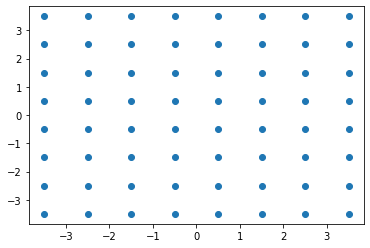

In [14]:
checkerboard = checkerboard_points(8,8)
plt.scatter(checkerboard[0,:], checkerboard[1,:])

#### 4.4 Checkerboard corners

Based on our original set of checkerboard corners, create three sets of rotated sets using the Rotation matrix R.

```Python
R = Rotation.from_euler('xyz', [θx, θy, θz]).as_matrix()
```

In [17]:
from scipy.spatial.transform import Rotation
Ra = Rotation.from_euler('xyz', [np.pi/10, 0, 0]).as_matrix()
Rb = Rotation.from_euler('xyz', [0, 0, 0]).as_matrix()
Rc = Rotation.from_euler('xyz', [-np.pi/10, 0, 0]).as_matrix()

Qa = Ra@checkerboard
Qb = Rb@checkerboard
Qc = Rc@checkerboard


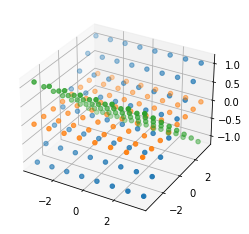

In [22]:
ax = plt.axes(projection='3d')
ax.scatter3D(Qa[0,:], Qa[1,:], Qa[2,:])
ax.scatter3D(Qb[0,:], Qb[1,:], Qb[2,:])
ax.scatter3D(Qc[0,:], Qc[1,:], Qc[2,:])

In [24]:
## Then project all points to the image plane
Qa_h = np.vstack((Qa, np.ones(len(Qa[0]))))
qa_h = P_exact@Qa_h
qa = qa_h[0:2, :]/qa_h[2, :]

Qb_h = np.vstack((Qb, np.ones(len(Qb[0]))))
qb_h = P_exact@Qb_h
qb = qb_h[0:2, :]/qb_h[2, :]

Qc_h = np.vstack((Qc, np.ones(len(Qc[0]))))
qc_h = P_exact@Qc_h
qc = qc_h[0:2, :]/qc_h[2, :]



#### 4.5 Zhangs method!

Now we will do zhangs method step by step, using our rotated checkerboard corners:
1. Estimate homography using the fact that the checkerboards are flat planes.


In [77]:
def hest(q1,q2):
    """
    Estimates H given points Q1, Q2 on the two image planes. 
    Need at least 4 pairs of points to estimate the matrix with 8 degrees of freedom.
    """
    q1,T1 = normalize2d(q1)
    q2,T2 = normalize2d(q2)
    assert len(q1[0])>1, "We need at least two points (aka two columns)"
    assert len(q1[0])==len(q2[0]), "Number of column of q1 and q2 must be equal!"
    B = get_b_old(q1,q2) #np.vstack((B0,B1))
    _,_,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(np.hstack((B.T,B)))
    H = np.reshape(VT[-1],(3,3)) # VT is sorted in descending order of singular value
    return (np.linalg.inv(T1)@H.T@T2.round(2))

def get_b_old(q1,q2):
    B = np.kron(q2[:,0], np.array([[0,-1,q1[1,0]],[1,0,-q1[0,0]],[-q1[1,0],q1[0,0],0]]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i], np.array([[0,-1,q1[1,i]],[1,0,-q1[0,i]],[-q1[1,i],q1[0,i],0]]))
        B = np.vstack((B,B_temp))
    return B

In [86]:
def estimateHomographies(Q_omega, qs):
    """
    params:
        - Q_omega: un-transformed checkerboard points in 3D
        - qs: Same points, but rotated/scaled/transformed and projected to the image frame.

    return:
        - An array of homography matrices that map Q_omega to each of the three image plane representations.
        q_i = H_i@Q_tilde, where Q_tilde is Q_omega but with removed z-coordinates and in homogenous representation.

    For each representation i we have a different homography H_i = K[r_i(1) r_i(2) t_i]. 
    This algorithm relies on "hest()" from ex2 - which used q1 q2 seen by two different cameras on a plane to estimate Homography
    between the two cameras:

        q1 = H1@Q, q2 = H2@Q
        Then H = H1@inv(H2) translates from one image plane to the next.

    In this case we can just assume that Q_omega is a virtual image plane with all the corners, and we find the homography mappings 
    from the image planes to this virtual image plane.

    """
    # Get the tilde representation
    Q_tilde = np.vstack((Q_omega[:2,:], np.ones(len(Q_omega[0]))))

    # Estimate H given points in image plane, and points on plane
    Hs = []
    for q in qs:
        # Cast to homogenous
        q_h = np.vstack((q, np.ones(len(q[0]))))
        Hs.append(hest(q_h, Q_tilde))
    return Hs

In [87]:
# Establish the parameters
Q_omega = checkerboard.copy()
qs = [qa.copy(), qb.copy(), qc.copy()]
# Estimate
Hs = estimateHomographies(Q_omega, qs)
np.int32(Hs)

array([[[  41,  -21,  555],
        [  41,   48,  312],
        [   0,    0,    0]],

       [[ -41,   41, -554],
        [ -41,  -41, -311],
        [   0,    0,    0]],

       [[  41,  -56,  555],
        [  41,   29,  312],
        [   0,    0,    0]]])

In [88]:
### Now we can test these homography matrices, as qij = Hi @ Q_tilde.
Q_omega = checkerboard.copy()
Q_tilde = np.vstack((Q_omega[:2,:], np.ones(len(Q_omega[0]))))
# Estimate using the H matrices
qa_est_h = Hs[0] @ Q_tilde
qb_est_h = Hs[1] @ Q_tilde
qc_est_h = Hs[2] @ Q_tilde
# Translate to inhomogenous coordinates
qa_est = qa_est_h[0:2, :]/qa_est_h[2, :]
qb_est = qb_est_h[0:2, :]/qb_est_h[2, :]
qc_est = qc_est_h[0:2, :]/qc_est_h[2, :]

In [106]:
print("Relative error:", np.sum((qa-qa_est)/np.linalg.norm(qa)))
print("Relative error:", np.sum((qb-qb_est)/np.linalg.norm(qb)))
print("Relative error:", np.sum((qc-qc_est)/np.linalg.norm(qc)))


Relative error: 6.835589765660094e-16
Relative error: -1.6742792048607402e-15
Relative error: 6.919158036236203e-16


#### 4.6 Estimate the B-vector and find K

Zhengyou Zhangs algorithm\
https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf

Next, define a function estimateIntrisics(Hs) that takes a list of homographies Hs and returns <br />
a camera matrix K. Use your estimate_b from the previous exercise. From b, estimate the <br />
camera matrix K (they use A in the paper). Find the solution in Appendix B from the paper


- The ith col of H is hi = [h1i, h2i, h3i].T
- Then: vij = [hi1 * hj1, hi1 * hj2 + hi2 * hj1, hi2 * hj2,
                    hi3 * hj1 + hi1 +hj3, hi3 * hj2 + hi2 * hj3, hi3 * hj3].T
    For two coloumns i and j of H.

- We do this for all n(=3) images, stacking the v's like this.
        
```
        [[v12.T]
        
         [(v11 - v22).T]
        
```
    We get one such v for each image, and stack them until we get V.

- Then we find B like this: Vb = 0, (9) use SVD!


    The solution to (9) is well known as the eigenvector of V.T@V associated with the smallest
eigenvalue (equivalently, the right singular vector of V associated with the smallest singular value).

- Now, we need K: B = inv(K).T@inv(K), use B to find intrinsic params \
![Appendix_B](Appendix_B.png)

- Use these intrinsic parameters to get both R and T! :D

In [158]:
def get_v(i, j, H):
    vij = np.asarray([H[i-1][0] * H[j-1][0], H[i-1][0] * H[j-1][1] + H[i-1][1] * H[j-1][0],
                      H[i-1][1] * H[j-1][1], H[i-1][2] * H[j-1][0] + H[i-1][0] + H[j-1][2],
                      H[i-1][2] * H[j-1][1] + H[i-1][1] * H[j-1][2], H[i-1][2] * H[j-1][2]])
    return vij

def get_V(Hs):
    v12 = get_v(1, 2, Hs[0])
    v11 = get_v(1, 1,  Hs[0])
    v22 = get_v(2, 2,  Hs[0])
    V = np.asarray([v12, v11-v22])

    for i in range(1, len(Hs)):
        v12 = get_v(1, 2, Hs[i])
        v11 = get_v(1, 1, Hs[i])
        v22 = get_v(2, 2, Hs[i])
        v = np.asarray([v12, v11-v22])
        V = np.vstack((V, v))
    return V

def appendix_B(b):
    """
    Once b is estimated, we can use it to find K! (Appendix B!)
    https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf
    """    
    B11, B12, B22, B13, B23, B33 = b[0], b[1], b[2], b[3], b[4], b[5]
    v0 = (B12*B13 - B11*B23)/(B11*B22 - B12**2)
    lam = B33 - (B13**2 + v0*(B12*B13 - B11*B23))/B11
    alpha = np.sqrt(lam/B11)
    beta = np.sqrt(lam*B11/(B11*B22 - B12**2))
    gamma = B12 * alpha**2 * beta/lam
    u0 = (gamma*v0/beta) - (B13 * alpha**2 / lam) 
    return v0, lam, alpha, beta, gamma, u0

def estimateIntrisics(Hs):
    '''
    Vb = 0
    B = inv(K).T@inv(K)
    '''
    # Get V
    V = get_V(Hs)
    _,_,VT = np.linalg.svd(V) # SVD!
    # Solution to SVD
    b = VT[-1] # b = [B11, B12, B22, B13, B23, B33].T
    print("b:", b)
    # We can then calcualate all the intrinsic parameters
    v0, lam, alpha, beta, gamma, u0 = appendix_B(b)
    print(v0, lam, alpha, beta, gamma, u0)

    

In [157]:
V = get_V(Hs)
print(V.shape)
estimateIntrisics(Hs)
K

(6, 6)
b: [-0.44095058  0.85443192 -0.25103371  0.07681722 -0.0811033  -0.00348099]
-0.04823127071849581 0.006633735364059446 nan 0.06872302984715611 nan nan


C:\Users\henri\AppData\Local\Temp\ipykernel_27928\3157037835.py:29: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(lam/B11)


array([[1000,    0,  960],
       [   0, 1000,  540],
       [   0,    0,    1]])

#### 4.7 Calculate rotation and translation matrices

![rot_trans](rot_transl.png)